In [286]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import project_env as pe
import sklearn as sklearn
from scipy import stats
%matplotlib inline

# IMPORT DATA

In [317]:
val_risk = pd.read_csv('results/val_risk.csv', encoding = "ISO-8859-1", low_memory=False, index_col=0)
rearrest_rates = pd.read_csv('results/rearrest_rates.csv', encoding = "ISO-8859-1", low_memory=False, index_col=0)
sada_not_charged = pd.read_csv('results/sada_not_charged.csv', encoding = "ISO-8859-1", low_memory=False, index_col=0)

In [318]:
#bring in ADA_CODE, year/month of decision, target variable
data = pd.read_csv('data_processing/output/merged.csv', encoding = "ISO-8859-1", low_memory=False)
data_simple = pd.read_csv('data_processing/output/data_simple.csv', encoding = "ISO-8859-1", low_memory=False)
                          
                          
val_risk_merged = pd.merge(val_risk, \
                 data[['UNIQUE_ID','NEXT_ARREST_TIME','ARREST_DATE_y',\
                      'SCREENING_DISP_DATE_y','SCREENING_DISP_DATE_m']],\
                 on='UNIQUE_ID', \
                 how='left')
val_risk_merged = pd.merge(val_risk_merged, \
                 data_simple[['UNIQUE_ID','ADA_CODE']],\
                 on='UNIQUE_ID', \
                 how='left')


val_risk_merged['NEXT_ARREST_TIME'] = val_risk_merged['NEXT_ARREST_TIME'].apply(pd.to_numeric)

In [319]:
#Create target
_temp, val_risk_merged['REARREST'] = pe.create_target(val_risk_merged,5)
del _temp

In [320]:
#bring in screener info
by_sada = pd.read_csv('results/by_sada.csv', encoding = "ISO-8859-1", low_memory=False)
val_risk_merged = pd.merge(val_risk_merged, \
                 by_sada,\
                 on='ADA_CODE', \
                 how='left')

In [321]:
#drop if ADA_CODE is missing
val_risk_merged = val_risk_merged.dropna(axis=0, subset = ['ADA_CODE'])

# DISTRIBUTION OF RISK

In [322]:
def predicted_risk_dist(data, risk):
    df = data[data['Risk']>=risk]
    grouped = df.groupby('SCREENING_DISP_DATE_y')['SCREENING_DISP_DATE_y'].count()
    plt.bar(grouped.index, grouped.values)
    plt.xticks(grouped.index, grouped.index.map(str), rotation=45)
    plt.title('Number of Arrestees with Risk > %s' %risk)
    plt.ylabel('Screening Year')
    plt.tight_layout()
    plt.show()

    return grouped

In [323]:
val_risk_merged.columns

Index(['BOFI_NBR', 'UNIQUE_ID', 'Risk', 'NEXT_ARREST_TIME', 'ARREST_DATE_y',
       'SCREENING_DISP_DATE_y', 'SCREENING_DISP_DATE_m', 'ADA_CODE',
       'REARREST', 'CHRG_ACCEPTED', 'CHRG_REJECTED', 'NBR_CASES', 'CHRG_RATE'],
      dtype='object')

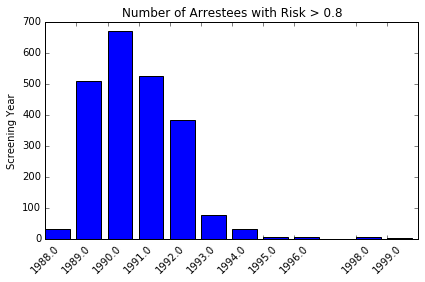

In [324]:
grouped = predicted_risk_dist(val_risk_merged,.80)

# REARREST RATES BY STRICT VS LENIENT

In [325]:
def get_rearrest_rate(sada_list, year):
    '''
    get rearrest rate for list of screeners
    '''
    data_trunc = sada_not_charged[(sada_not_charged['ARREST_DATE_y'] <= 1999 - year)]
    data_trunc = data_trunc[data_trunc['ADA_CODE'].isin(sada_list)]
    total = data_trunc['SCREENING_DISP_CODE'].count()
    rearrest_cnt = data_trunc[(data_trunc['NEXT_ARREST_TIME'] >0)&(data_trunc['NEXT_ARREST_TIME'] <= year*365)]\
            ['SCREENING_DISP_CODE'].count()
    rearrest_rate = rearrest_cnt/total
    return rearrest_rate

In [326]:
len_rate_lower = .3
len_rate_upper = .4
strict_rate_lower = .4
strict_rate_upper = .5
lenient = val_risk_merged[(val_risk_merged['CHRG_RATE']>len_rate_lower)&\
                          (val_risk_merged['CHRG_RATE']<=len_rate_upper)].copy()
strict = val_risk_merged[(val_risk_merged['CHRG_RATE']>strict_rate_lower)&\
                          (val_risk_merged['CHRG_RATE']<=strict_rate_upper)].copy()
years = 5

lenient.sort_values('Risk',ascending=False,inplace=True)

In [327]:
len_sada_list = lenient[['ADA_CODE','NBR_CASES','CHRG_ACCEPTED']].drop_duplicates()
len_chrg_rate =  len_sada_list['CHRG_ACCEPTED'].sum()/len_sada_list['NBR_CASES'].sum()
len_rearrest_rate = get_rearrest_rate(lenient['ADA_CODE'].unique(),years)

strict_sada_list = strict[['ADA_CODE','NBR_CASES','CHRG_ACCEPTED']].drop_duplicates()
strict_chrg_rate =  strict_sada_list['CHRG_ACCEPTED'].sum()/strict_sada_list['NBR_CASES'].sum()
strict_rearrest_rate = get_rearrest_rate(strict['ADA_CODE'].unique(),years)


In [328]:
tot_cases_len = int(lenient.shape[0]/(1-len_chrg_rate))

print('An estimated %s total arrestees were seen by screeners with charge rate between %d%% and %d%% in the validation set.'\
      %(tot_cases_len,len_rate_lower*100,len_rate_upper*100))
print('The weighted average charge rate for those screeners was %d%% and %d%% of those released were rearrested\n'\
      %(len_chrg_rate*100,len_rearrest_rate*100))

tot_cases_strict = int(strict.shape[0]/(1-strict_chrg_rate))

print('%s total arrestees seen by screeners with charge rate between %d%% and %d%% in the validation set.'\
      %(tot_cases_strict,strict_rate_lower*100,strict_rate_upper*100))
print('The weighted average charge rate for those screeners was %d%% and %d%% of those released were rearrested\n'\
      %(strict_chrg_rate*100,strict_rearrest_rate*100))

target_chrgs = int(tot_cases_len*(strict_chrg_rate-len_chrg_rate))
marginal_rearrest_rate = lenient[:target_chrgs]['REARREST'].sum()/target_chrgs
tot_rearrest_rate = (lenient['REARREST'].sum()-lenient[:target_chrgs]['REARREST'].sum())/\
                    (tot_cases_len*(1-len_chrg_rate)-target_chrgs)
new_chrg_rate = (len_chrg_rate*tot_cases_len+target_chrgs)/tot_cases_len

print('%s additional arrestees need to be charged for the lenient screeners to have a charge rate of %d%%.'\
      %(target_chrgs,strict_chrg_rate*100))
print('Out of the %s predicted riskiest arrestees, %d were rearrested, a rearrest rate of %d%%.' \
      %(target_chrgs,marginal_rearrest_rate*target_chrgs,marginal_rearrest_rate*100))
print('If those %s were charged, the rearrest rate for the "lenient screeners" would be %d%%.' \
      %(target_chrgs,tot_rearrest_rate*100))
print('If those %s were charged, the charge rate for the "lenient screeners" would be %d%%.' \
      %(target_chrgs,new_chrg_rate*100))

An estimated 7747 total arrestees were seen by screeners with charge rate between 30% and 40% in the validation set.
The weighted average charge rate for those screeners was 35% and 54% of those released were rearrested

3580 total arrestees seen by screeners with charge rate between 40% and 50% in the validation set.
The weighted average charge rate for those screeners was 43% and 53% of those released were rearrested

565 additional arrestees need to be charged for the lenient screeners to have a charge rate of 43%.
Out of the 565 predicted riskiest arrestees, 512 were rearrested, a rearrest rate of 90%.
If those 565 were charged, the rearrest rate for the "lenient screeners" would be 48%.
If those 565 were charged, the charge rate for the "lenient screeners" would be 43%.


In [329]:
def get_p_value(threshold, n=1000):
    rearrest_rates = np.zeros(n)
    for i in range(n):
        lenient_rand = lenient.reindex(np.random.permutation(lenient.index))
        rearrest_rates[i] = (lenient['REARREST'].sum()-lenient_rand[:target_chrgs]['REARREST'].sum())/\
                        (tot_cases_len*(1-len_chrg_rate)-target_chrgs)
    p_value = len(rearrest_rates[rearrest_rates<=threshold])/n
    return p_value, rearrest_rates

In [330]:
p_value, rearrest_rates_rand = get_p_value(.49, n=1000)

In [331]:
p_value

0.0

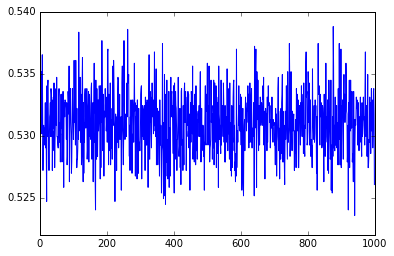

In [332]:
plt.plot(rearrest_rates_rand)

# Distribution of Risk for strict vs lenient

In [342]:
#Assign quintiles of predicted risk
val_risk_merged['q_risk'] = pd.qcut(val_risk_merged['Risk'],5,labels=False)
val_risk_merged['q_chrg_rate'] = pd.qcut(val_risk_merged['CHRG_RATE'],5,labels=False)

In [511]:
avg_by_chrg_rate = val_risk_merged.groupby(['q_chrg_rate'])['CHRG_RATE','Risk'].mean()

In [512]:
avg_by_chrg_rate

,CHRG_RATE,Risk
q_chrg_rate,,
0.0,0.222960,0.487485
1.0,0.350445,0.517943
2.0,0.389878,0.548238
3.0,0.440126,0.535199
4.0,0.578116,0.524417


In [515]:
avg_by_risk = val_risk_merged.groupby(['q_risk'])['Risk','CHRG_RATE'].mean()
avg_by_risk

,Risk,CHRG_RATE
q_risk,,
0,0.113809,0.354600
1,0.324872,0.392195
2,0.546389,0.406838
3,0.748822,0.411732
4,0.879700,0.374540


In [467]:
by_chrg_rate = val_risk_merged.groupby(['q_chrg_rate','q_risk'])['UNIQUE_ID'].count()
by_chrg_rate = by_chrg_rate.reset_index()
by_chrg_rate['tot_by_chrg_rate'] = by_chrg_rate.groupby('q_chrg_rate')['UNIQUE_ID'].transform('sum')
by_chrg_rate['q_risk_share'] = by_chrg_rate['UNIQUE_ID']/by_chrg_rate['tot_by_chrg_rate']
by_chrg_rate = by_chrg_rate.rename(columns={'UNIQUE_ID': 'count'})


In [487]:
plot_data = by_chrg_rate.pivot(index='q_chrg_rate', columns='q_risk', \
                               values='q_risk_share').reset_index().drop('q_chrg_rate',1)

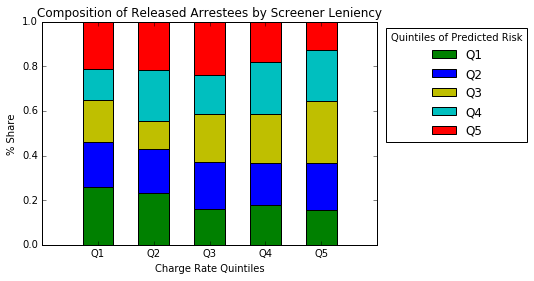

In [502]:

ind = np.arange(5)    # the x locations for the groups
width = 0.55       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, plot_data[0.0], width, align='center', color='g')
p2 = plt.bar(ind, plot_data[1.0], width, align='center', bottom=plot_data[0.0], color='b')
p3 = plt.bar(ind, plot_data[2.0], width, align='center', bottom=plot_data[1.0] +plot_data[0.0], color='y')
p4 = plt.bar(ind, plot_data[3.0], width, align='center', bottom=plot_data[2.0] + plot_data[1.0] +plot_data[0.0], color='c')
p5 = plt.bar(ind, plot_data[4.0], width, align='center', bottom=plot_data[3.0] + plot_data[2.0] + plot_data[1.0] +plot_data[0.0], color='r')

plt.ylabel('% Share')
plt.title('Composition of Released Arrestees by Screener Leniency')
plt.xticks(ind, ('Q1', 'Q2','Q3','Q4','Q5'))
plt.xlabel('Charge Rate Quintiles')
plt.legend((p1[0], p2[0],p3[0],p4[0],p5[0]), ('Q1', 'Q2','Q3','Q4','Q5'),title='Quintiles of Predicted Risk',\
           bbox_to_anchor=(1.01, 1), loc=2, ncol=1)

plt.show()


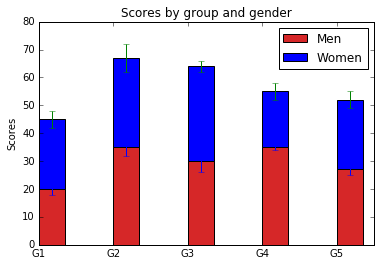

In [475]:
N = 5
menMeans = (20, 35, 30, 35, 27)
womenMeans = (25, 32, 34, 20, 25)
menStd = (2, 3, 4, 1, 2)
womenStd = (3, 5, 2, 3, 3)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, menMeans, width, color='#d62728', yerr=menStd)
p2 = plt.bar(ind, womenMeans, width,
             bottom=menMeans, yerr=womenStd)

plt.ylabel('Scores')
plt.title('Scores by group and gender')
plt.xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()

In [382]:
by_chrg_rate = val_risk_merged.groupby(['q_chrg_rate','q_risk'])['UNIQUE_ID'].count()
by_chrg_rate.groupby(level=[0]).apply(lambda x: x / x.sum()).values

array([ 0.2611336 ,  0.19736842,  0.1902834 ,  0.13815789,  0.21305668,
        0.23235294,  0.19852941,  0.12352941,  0.22794118,  0.21764706,
        0.16018307,  0.20938215,  0.21453089,  0.17734554,  0.23855835,
        0.17835366,  0.18648374,  0.2195122 ,  0.23373984,  0.18191057,
        0.1574904 ,  0.20934699,  0.27528809,  0.22983355,  0.12804097])

# Rearrest Rates by Predicted Risk

In [335]:
val_risk_merged.head()

,BOFI_NBR,UNIQUE_ID,Risk,NEXT_ARREST_TIME,ARREST_DATE_y,SCREENING_DISP_DATE_y,SCREENING_DISP_DATE_m,ADA_CODE,REARREST,CHRG_ACCEPTED,CHRG_REJECTED,NBR_CASES,CHRG_RATE,q_risk,q_chrg_rate
1,325011,127976,0.070880,0,1992.0,1992.0,3.0,PMOR,0,522.0,716.0,1238.0,0.421648,0,3.0
3,306688,63012,0.940634,137,1990.0,1991.0,11.0,CKEM,1,1726.0,3523.0,5249.0,0.328825,4,0.0
4,310664,81452,0.372344,409,1991.0,1991.0,3.0,JHAN,1,222.0,311.0,533.0,0.416510,1,3.0
6,188857,81615,0.421166,1,1993.0,1993.0,6.0,JLUC,1,4434.0,3610.0,8044.0,0.551218,1,4.0
7,317574,105477,0.303787,545,1993.0,1993.0,4.0,DLIL,1,569.0,939.0,1508.0,0.377321,1,2.0


In [304]:
def chrg_rate_by_risk(chrg_rate_lower,chrg_rate_upper):
    chrg_rate_bin = val_risk_merged[(val_risk_merged['CHRG_RATE']>chrg_rate_lower)&\
                              (val_risk_merged['CHRG_RATE']<=chrg_rate_upper)].copy()
    chrg_rate_bin['quintile'] = pd.qcut(chrg_rate_bin['Risk'],5,labels=False)
    chrg_rate_bin['count'] = 1
    chrg_rate_bin_q = chrg_rate_bin.groupby('quintile')[['REARREST','count']].sum()
    chrg_rate_bin_q['rearrest_rate']=chrg_rate_bin_q['REARREST']/chrg_rate_bin_q['count']
    print('Arrestees released by screeners with charge rates of %d%% to %d%%' %(chrg_rate_lower*100,chrg_rate_upper*100))
    print(chrg_rate_bin_q)

In [305]:
chrg_rate_by_risk(0,1)
chrg_rate_by_risk(.3,.4)
chrg_rate_by_risk(.4,.5)
chrg_rate_by_risk(.5,.6)

Arrestees released by screeners with charge rates of 0% to 100%
          REARREST  count  rearrest_rate
quintile                                
0              231   1836       0.125817
1              592   1835       0.322616
2              983   1836       0.535403
3             1380   1835       0.752044
4             1607   1836       0.875272
Arrestees released by screeners with charge rates of 30% to 40%
          REARREST  count  rearrest_rate
quintile                                
0              119    992       0.119960
1              319    992       0.321573
2              533    992       0.537298
3              786    992       0.792339
4              877    992       0.884073
Arrestees released by screeners with charge rates of 40% to 50%
          REARREST  count  rearrest_rate
quintile                                
0               53    407       0.130221
1              150    406       0.369458
2              243    406       0.598522
3              301    406    

In [306]:
chrg_rate_by_risk(0,1)

Arrestees released by screeners with charge rates of 0% to 100%
          REARREST  count  rearrest_rate
quintile                                
0              231   1836       0.125817
1              592   1835       0.322616
2              983   1836       0.535403
3             1380   1835       0.752044
4             1607   1836       0.875272


# Racial Analysis

In [307]:
risk_race = pd.merge(val_risk, \
                 data[['UNIQUE_ID','RACE','NEXT_ARREST_TIME']],\
                 on='UNIQUE_ID', \
                 how='left')

val_pred = pd.read_csv('results/val_pred.csv', encoding = "ISO-8859-1", low_memory=False, index_col=0)

risk_race = pd.merge(risk_race, \
                 val_pred,\
                 on='UNIQUE_ID', \
                 how='left')


risk_race = pd.merge(risk_race, \
                 data_simple[['UNIQUE_ID','ADA_CODE']],\
                 on='UNIQUE_ID', \
                 how='left')

risk_race = pd.merge(risk_race, \
                 by_sada,\
                 on='ADA_CODE', \
                 how='left')


risk_race = risk_race.dropna(axis=0, subset = ['ADA_CODE'])

In [308]:
chrg_rate_lower = 0
chrg_rate_upper = 1

by_race_W = risk_race[(risk_race['CHRG_RATE']>len_rate_lower)&\
                          (risk_race['CHRG_RATE']<=len_rate_upper)&\
                          (risk_race['RACE']=='W')
                     ].copy()
by_race_B = risk_race[(risk_race['CHRG_RATE']>len_rate_lower)&\
                          (risk_race['CHRG_RATE']<=len_rate_upper)&\
                          (risk_race['RACE']=='B')
                     ].copy()

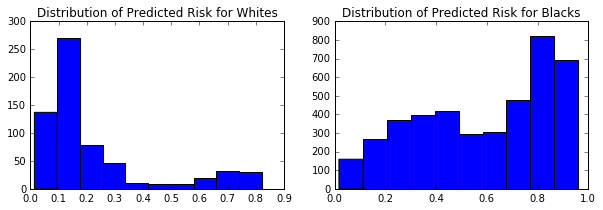

In [309]:

fig,ax = plt.subplots(1,2,figsize=(10,3))
ax[0].hist(by_race_W['Risk'])
ax[0].set_title('Distribution of Predicted Risk for Whites')
ax[1].hist(by_race_B['Risk'])
ax[1].set_title('Distribution of Predicted Risk for Blacks')

In [310]:
by_race_W.shape[0]

642

In [311]:
num_released_W = by_race_W.groupby('true_y')['true_y'].count().sum()
rearrest_rate_W = by_race_W.groupby('true_y')['true_y'].count()[0]/num_released_W
num_released_B = by_race_B.groupby('true_y')['true_y'].count().sum()
rearrest_rate_B = by_race_B.groupby('true_y')['true_y'].count()[0]/num_released_B
print('Out of %s whites released, %d%% were rearrested within 5 years.' %(num_released_W,rearrest_rate_W*100))
print('Out of %s blacks released, %d%% were rearrested within 5 years.' %(num_released_B,rearrest_rate_B*100))


pred_rearrest_rate_B = by_race_B.groupby('pred_y')['pred_y'].count()[0]/num_released_B
pred_rearrest_rate_W = by_race_W.groupby('pred_y')['pred_y'].count()[0]/num_released_W
print('Out of %s whites released, %d%% were PREDICTED to be rearrested within 5 years.' %(num_released_W,pred_rearrest_rate_W*100))
print('Out of %s blacks released, %d%% were PREDICTED to be rearrested within 5 years.' %(num_released_B,pred_rearrest_rate_B*100))

Out of 642 whites released, 76% were rearrested within 5 years.
Out of 4203 blacks released, 41% were rearrested within 5 years.
Out of 642 whites released, 85% were PREDICTED to be rearrested within 5 years.
Out of 4203 blacks released, 39% were PREDICTED to be rearrested within 5 years.


In [312]:
pred_rearrest_W = by_race_W[(by_race_W['pred_y']==1)].shape[0]
fp_W = by_race_W[(by_race_W['true_y']==0)&(by_race_W['pred_y']==1)].shape[0]/pred_rearrest_W

pred_rearrest_B = by_race_B[(by_race_B['pred_y']==1)].shape[0]
fp_B = by_race_B[(by_race_B['true_y']==0)&(by_race_B['pred_y']==1)].shape[0]/pred_rearrest_B


print('Out of %s whites that were predicted to be rearrested, \
    %d%% were false positives.' %(pred_rearrest_W,fp_W*100))
print('Out of %s blacks that were predicted to be rearrested, \
    %d%% were false positives.' %(pred_rearrest_B,fp_B*100))

Out of 91 whites that were predicted to be rearrested,     24% were false positives.
Out of 2549 blacks that were predicted to be rearrested,     21% were false positives.


In [313]:
pred_no_rearrest_W = by_race_W[(by_race_W['pred_y']==0)].shape[0]
fn_W = by_race_W[(by_race_W['true_y']==1)&(by_race_W['pred_y']==0)].shape[0]/pred_no_rearrest_W

pred_no_rearrest_B = by_race_B[(by_race_B['pred_y']==0)].shape[0]
fn_B = by_race_B[(by_race_B['true_y']==1)&(by_race_B['pred_y']==0)].shape[0]/pred_no_rearrest_B


print('Out of %s whites that were predicted to not be rearrested, \
    %d%% were false negatives.' %(pred_no_rearrest_W,fn_W*100))
print('Out of %s blacks that were predicted to not be rearrested, \
    %d%% were false negatives.' %(pred_no_rearrest_B,fn_B*100))

Out of 551 whites that were predicted to not be rearrested,     15% were false negatives.
Out of 1654 blacks that were predicted to not be rearrested,     28% were false negatives.
